<a href="https://colab.research.google.com/github/bcgsc/pori/blob/feature%2Fcolab-notebooks/docs/ipr/scripting/RNA_Expression_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the Data

First we need to download the dataset we will use. We are going to use the TCGA data here since it is publically available and well known ([UCSC Xena TCGA PANCAN](https://xenabrowser.net/datapages/?cohort=TCGA%20Pan-Cancer%20(PANCAN))). We will download the TPM matrix as well as the corresponding metadata file

In [38]:
!wget https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_RSEM_gene_tpm.gz
!wget https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp

--2021-06-09 19:24:14--  https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_RSEM_gene_tpm.gz
Resolving toil-xena-hub.s3.us-east-1.amazonaws.com (toil-xena-hub.s3.us-east-1.amazonaws.com)... 52.216.80.45
Connecting to toil-xena-hub.s3.us-east-1.amazonaws.com (toil-xena-hub.s3.us-east-1.amazonaws.com)|52.216.80.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740772247 (706M) [binary/octet-stream]
Saving to: ‘tcga_RSEM_gene_tpm.gz.1’

tcga_RSEM_gene_tpm. 100%[===================>] 706.46M  25.4MB/s    in 24s     

2021-06-09 19:24:38 (30.0 MB/s) - ‘tcga_RSEM_gene_tpm.gz.1’ saved [740772247/740772247]

--2021-06-09 19:24:38--  https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp
Resolving tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com (tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com)... 52.217.93.16
Connecting to tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com (tcga-pancan-atlas-hub.s3.

The matrix we have downloaded is very large as it contains many different disease cohorts. For the purposes of this tutorial we want a smaller dataset so we are going to choose the smallest TCGA cohort, CHOL. To do this we need to use the metadata file to subset the main matrix file

## Install Dependencies

For the following tutorial we are going to use some common data processing and visualization libraries in python: seaborn and pandas. We need to install them before we proceed

In [39]:
!pip install pandas seaborn

## Create the Disease Matrix Subset

First read the metadata file


In [61]:
import json

import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

sns.set_style('whitegrid')

In [41]:
meta_df = pd.read_csv('Survival_SupplementalTable_S1_20171025_xena_sp', sep='\t')
meta_df

,sample,_PATIENT,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-OR-A5J1-01,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,NaN,Adrenocortical carcinoma- Usual Type,NaN,2000.0,NaN,-21496.0,Dead,WITH TUMOR,NaN,1355.0,NaN,Distant Metastasis,Peritoneal Surfaces,NaN,754.0,Complete Remission/Response,NaN,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,TCGA-OR-A5J2-01,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,NaN,Adrenocortical carcinoma- Usual Type,NaN,2004.0,NaN,-16090.0,Dead,WITH TUMOR,NaN,1677.0,NaN,Distant Metastasis,Soft Tissue,NaN,289.0,Progressive Disease,NaN,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,TCGA-OR-A5J3-01,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,NaN,Adrenocortical carcinoma- Usual Type,NaN,2008.0,NaN,-8624.0,Alive,WITH TUMOR,2091.0,NaN,NaN,Distant Metastasis,Lung,NaN,53.0,Complete Remission/Response,NaN,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,TCGA-OR-A5J4-01,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,NaN,Adrenocortical carcinoma- Usual Type,NaN,2000.0,NaN,-8451.0,Dead,WITH TUMOR,NaN,423.0,NaN,Locoregional Recurrence,Peritoneal Surfaces,NaN,126.0,Progressive Disease,NaN,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,TCGA-OR-A5J5-01,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,NaN,Adrenocortical carcinoma- Usual Type,NaN,2000.0,NaN,-11171.0,Dead,WITH TUMOR,NaN,365.0,NaN,Locoregional Recurrence,"Other, specify",vena cava thrombus,50.0,Progressive Disease,NaN,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12586,TCGA-YZ-A980-01,TCGA-YZ-A980,UVM,75.0,MALE,WHITE,Stage IIIA,Stage IIIA,Spindle Cell|Epithelioid Cell,NaN,2010.0,NaN,-27716.0,Alive,TUMOR FREE,1862.0,NaN,NaN,New Primary Tumor,"Other, specify",Scalp,1556.0,NaN,NaN,NaN,0.0,1862.0,0.0,1862.0,NaN,NaN,1.0,1556.0,NaN
12587,TCGA-YZ-A982-01,TCGA-YZ-A982,UVM,79.0,FEMALE,WHITE,Stage IIIB,Stage IIIB,Spindle Cell,NaN,2013.0,NaN,-28938.0,Alive,TUMOR FREE,495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,495.0,0.0,495.0,NaN,NaN,0.0,495.0,NaN
12588,TCGA-YZ-A983-01,TCGA-YZ-A983,UVM,51.0,FEMALE,WHITE,Stage IIB,Stage IIB,Epithelioid Cell,NaN,2013.0,NaN,-18769.0,Alive,TUMOR FREE,798.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,798.0,0.0,798.0,NaN,NaN,0.0,798.0,NaN
12589,TCGA-YZ-A984-01,TCGA-YZ-A984,UVM,50.0,FEMALE,WHITE,Stage IIB,Stage IIIA,Spindle Cell|Epithelioid Cell,NaN,2011.0,NaN,-18342.0,Dead,WITH TUMOR,NaN,1396.0,Metastatic Uveal Melanoma,New Primary Tumor,"Other, specify",Thyroid,154.0,NaN,NaN,NaN,1.0,1396.0,1.0,1396.0,NaN,NaN,1.0,154.0,NaN


Now select the rows which match the disease we are intereseted in, CHOL. Print out the number of rows after the selecton. There should be 45

In [42]:
chol_meta_df = meta_df[meta_df['cancer type abbreviation'] == 'CHOL']
chol_meta_df.shape[0]

45

Next we are going to read in the data matrix. We will use the metadata we just collected to only load the columns for the cohort of interest. This will save memory and speed up the process. This will still probably take a few seconds.

In [43]:
columns_to_keep = ['sample'] + chol_meta_df['sample'].tolist()
chol_matrix = pd.read_csv('tcga_RSEM_gene_tpm.gz', compression='gzip', sep='\t', usecols=columns_to_keep)

To make things less confusing we will rename the "sample" column as "gene" since that is what is actually in that column

In [44]:
chol_matrix = chol_matrix.rename(columns={'sample': 'gene'})
chol_matrix = chol_matrix.set_index('gene')
chol_matrix

,TCGA-ZH-A8Y5-01,TCGA-4G-AAZT-01,TCGA-W5-AA2R-11,TCGA-W5-AA2I-01,TCGA-W5-AA34-01,TCGA-W5-AA2X-01,TCGA-W5-AA2H-01,TCGA-3X-AAVB-01,TCGA-3X-AAVA-01,TCGA-ZH-A8Y4-01,TCGA-W5-AA31-11,TCGA-W5-AA2U-01,TCGA-W5-AA2Q-01,TCGA-ZH-A8Y2-01,TCGA-W5-AA30-01,TCGA-WD-A7RX-01,TCGA-ZU-A8S4-11,TCGA-W5-AA2U-11,TCGA-3X-AAVE-01,TCGA-W5-AA2G-01,TCGA-W5-AA39-01,TCGA-4G-AAZO-01,TCGA-W5-AA2R-01,TCGA-W5-AA34-11,TCGA-W5-AA2I-11,TCGA-W6-AA0S-01,TCGA-W5-AA2W-01,TCGA-YR-A95A-01,TCGA-W5-AA33-01,TCGA-ZD-A8I3-01,TCGA-W5-AA2O-01,TCGA-W5-AA31-01,TCGA-W5-AA2Q-11,TCGA-W5-AA36-01,TCGA-W5-AA38-01,TCGA-ZU-A8S4-01,TCGA-W5-AA2Z-01,TCGA-3X-AAVC-01,TCGA-W5-AA30-11,TCGA-ZH-A8Y1-01,TCGA-3X-AAV9-01,TCGA-W5-AA2T-01,TCGA-ZH-A8Y6-01,TCGA-ZH-A8Y8-01,TCGA-W5-AA2X-11
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000242268.2,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-4.2934,-9.9658,-4.2934,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-4.0350,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-4.0350,-9.9658,-3.8160,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
ENSG00000259041.1,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
ENSG00000270112.3,-9.9658,-9.9658,-9.9658,-6.5064,-6.5064,-9.9658,-9.9658,-1.9942,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-3.1714,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-6.5064,-6.5064,-9.9658
ENSG00000167578.16,4.0575,5.2430,3.1179,4.3716,4.6282,4.7203,6.7259,5.4233,4.4243,4.8105,3.2841,3.9892,3.8778,5.6244,4.7345,4.9175,3.3647,3.4277,4.8405,4.0046,5.7520,4.6955,5.0104,3.1393,3.2282,4.9855,5.9074,4.2958,4.6106,4.8510,4.5940,5.3035,3.8993,4.6525,5.6795,5.4216,4.2297,4.6101,3.7846,4.8802,4.8905,4.2025,5.7632,5.1611,3.8808
ENSG00000278814.1,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000273233.1,-9.9658,-1.9942,-9.9658,-1.5951,-3.3076,-9.9658,-3.4580,-3.0469,-3.1714,-0.6873,-9.9658,-2.2447,-3.1714,-9.9658,-0.1504,-3.4580,-9.9658,-9.9658,-9.9658,-3.0469,-2.2447,-9.9658,-9.9658,-9.9658,-3.6259,-3.4580,-2.7274,-9.9658,-3.0469,-1.9379,-9.9658,-9.9658,-9.9658,-1.2828,-9.9658,-1.9942,-3.1714,-9.9658,-3.3076,-9.9658,-9.9658,-0.9132,-3.1714,-3.4580,-9.9658
ENSG00000105063.18,5.1157,4.9901,3.5187,5.1277,4.6713,4.9322,6.0830,5.5604,5.1056,4.8445,3.2374,4.9275,4.7049,5.2327,4.9589,4.6910,2.9224,2.8462,5.4266,5.3005,4.3876,5.4654,5.0246,3.3842,2.8096,4.0207,5.8985,4.6944,5.4199,4.9741,5.1027,5.8483,3.5742,5.1211,5.4019,5.2114,4.7939,5.8783,2.9839,5.0747,5.0352,5.2250,5.6744,4.9978,3.4778
ENSG00000231119.2,-4.2934,-5.5735,-3.8160,-9.9658,-6.5064,-2.6349,-5.5735,-3.3076,-9.9658,-4.0350,-3.1714,-4.2934,-5.5735,-9.9658,-4.0350,-2.8262,-3.4580,-5.0116,-4.6082,-3.6259,-5.0116,-4.2934,-3.8160,-3.0469,-4.0350,-4.2934,-2.2447,-3.6259,-3.8160,-5.5735,-4.6082,-2.1140,-3.0469,-9.9658,-3.6259,-1.8314,-3.8160,-4.6082,-3.3076,-3.1714,-2.4659,-4.0350,-2.4659,-2.7274,-2.9324


Now that we have our matrix we are ready to start calculating metrics

## Calculating Metrics

The input for an analysis where a patient sample is being compared to the TCGA cohort of interest would typically be an expression matrix using the same normalization method as the comparator cohort. Note: Differences in library preparation, sequencing and bioinformatics pipelines can lead to variation in expression quantification. It is important to understand the impact these differences have on expression quantification before comparing expression values that are produced using different pipelines.

For the purposes of this tutorial we are going to choose one of the CHOL samples from our expression matrix to use as our input. We arbitrarily chose the first sample.


In [45]:
test_sample_id = chol_meta_df['sample'].tolist()[0]

### Percentile

We will start by calculating the percentile rank

In [46]:
percentiles = chol_matrix.copy()
percentiles = percentiles.rank(1, pct=True, numeric_only=True).apply(lambda x: round(x * 100))
percentiles

,TCGA-ZH-A8Y5-01,TCGA-4G-AAZT-01,TCGA-W5-AA2R-11,TCGA-W5-AA2I-01,TCGA-W5-AA34-01,TCGA-W5-AA2X-01,TCGA-W5-AA2H-01,TCGA-3X-AAVB-01,TCGA-3X-AAVA-01,TCGA-ZH-A8Y4-01,TCGA-W5-AA31-11,TCGA-W5-AA2U-01,TCGA-W5-AA2Q-01,TCGA-ZH-A8Y2-01,TCGA-W5-AA30-01,TCGA-WD-A7RX-01,TCGA-ZU-A8S4-11,TCGA-W5-AA2U-11,TCGA-3X-AAVE-01,TCGA-W5-AA2G-01,TCGA-W5-AA39-01,TCGA-4G-AAZO-01,TCGA-W5-AA2R-01,TCGA-W5-AA34-11,TCGA-W5-AA2I-11,TCGA-W6-AA0S-01,TCGA-W5-AA2W-01,TCGA-YR-A95A-01,TCGA-W5-AA33-01,TCGA-ZD-A8I3-01,TCGA-W5-AA2O-01,TCGA-W5-AA31-01,TCGA-W5-AA2Q-11,TCGA-W5-AA36-01,TCGA-W5-AA38-01,TCGA-ZU-A8S4-01,TCGA-W5-AA2Z-01,TCGA-3X-AAVC-01,TCGA-W5-AA30-11,TCGA-ZH-A8Y1-01,TCGA-3X-AAV9-01,TCGA-W5-AA2T-01,TCGA-ZH-A8Y6-01,TCGA-ZH-A8Y8-01,TCGA-W5-AA2X-11
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000242268.2,46.0,46.0,46.0,46.0,46.0,46.0,46.0,92.0,46.0,92.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,97.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,97.0,46.0,100.0,46.0,46.0,46.0,46.0,46.0
ENSG00000259041.1,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0
ENSG00000270112.3,44.0,44.0,44.0,92.0,92.0,44.0,44.0,100.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,98.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,92.0,92.0,44.0
ENSG00000167578.16,29.0,80.0,2.0,38.0,49.0,56.0,100.0,87.0,40.0,60.0,9.0,24.0,18.0,89.0,58.0,71.0,11.0,13.0,62.0,27.0,93.0,53.0,76.0,4.0,7.0,73.0,98.0,36.0,47.0,64.0,42.0,82.0,22.0,51.0,91.0,84.0,33.0,44.0,16.0,67.0,69.0,31.0,96.0,78.0,20.0
ENSG00000278814.1,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000273233.1,23.0,86.0,23.0,91.0,59.0,23.0,52.0,73.0,66.0,98.0,23.0,81.0,66.0,23.0,100.0,52.0,23.0,23.0,23.0,73.0,81.0,23.0,23.0,23.0,47.0,52.0,78.0,23.0,73.0,89.0,23.0,23.0,23.0,93.0,23.0,86.0,66.0,23.0,59.0,23.0,23.0,96.0,66.0,52.0,23.0
ENSG00000105063.18,64.0,49.0,18.0,69.0,27.0,42.0,100.0,89.0,62.0,38.0,11.0,40.0,33.0,76.0,44.0,29.0,7.0,4.0,84.0,78.0,24.0,87.0,53.0,13.0,2.0,22.0,98.0,31.0,82.0,47.0,60.0,93.0,20.0,67.0,80.0,71.0,36.0,96.0,9.0,58.0,56.0,73.0,91.0,51.0,16.0
ENSG00000231119.2,37.0,17.0,54.0,6.0,11.0,89.0,17.0,70.0,6.0,46.0,74.0,37.0,17.0,6.0,46.0,84.0,67.0,23.0,29.0,62.0,23.0,37.0,54.0,79.0,46.0,37.0,96.0,62.0,54.0,17.0,29.0,98.0,79.0,6.0,62.0,100.0,54.0,29.0,70.0,74.0,92.0,46.0,92.0,87.0,82.0


We can plot a couple of these as a sanity check. The line plots should never go up and then down again

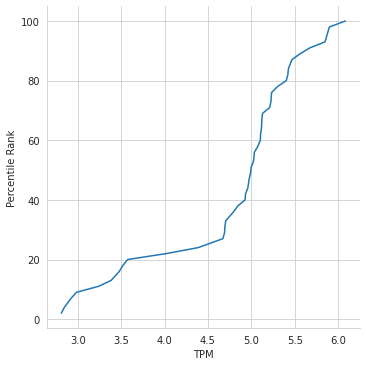

In [47]:
gene = 'ENSG00000105063.18'

fig = sns.relplot(kind='line', x=chol_matrix.loc[gene], y=percentiles.loc[gene])
fig.set(xlabel='TPM', ylabel='Percentile Rank')

Now let's look at the percentiles for our test sample

In [48]:
percentiles[[test_sample_id]]

,TCGA-3X-AAV9-01
gene,
ENSG00000242268.2,46.0
ENSG00000259041.1,51.0
ENSG00000270112.3,44.0
ENSG00000167578.16,69.0
ENSG00000278814.1,51.0
...,...
ENSG00000273233.1,23.0
ENSG00000105063.18,56.0
ENSG00000231119.2,92.0


We can select the highest and lowest percentiles as a way to look for possible outliers (arbitrarily selecting 95 and 5 as thresholds).

In [49]:
percentiles[[test_sample_id]][(percentiles[test_sample_id] >= 95) | (percentiles[test_sample_id] <= 5)]

,TCGA-3X-AAV9-01
gene,
ENSG00000280143.1,98.0
ENSG00000232001.1,98.0
ENSG00000206072.12,100.0
ENSG00000254102.1,100.0
ENSG00000165312.6,100.0
...,...
ENSG00000103241.6,100.0
ENSG00000237803.5,100.0
ENSG00000270987.1,98.0


### Calculating kIQR

The next metric we are going to look at is the kIQR. This metric is different from percentile in that it takes into account the spread or variance of the distribution. To be able to calculate this we first need to calculate some parameters for each gene

In [50]:
quantiles = pd.concat([
  chol_matrix[test_sample_id], 
  chol_matrix.quantile(0.25, 1), 
  chol_matrix.quantile(0.5, 1), 
  chol_matrix.quantile(0.75, 1),
], axis=1).rename(
    columns={0.25: 'q1', 0.5: 'q2', 0.75: 'q3', test_sample_id: 'tpm'}
).reset_index()
quantiles['iqr'] = quantiles.q3 - quantiles.q1
quantiles

,gene,tpm,q1,q2,q3,iqr
0,ENSG00000242268.2,-9.9658,-9.9658,-9.9658,-9.9658,0.0000
1,ENSG00000259041.1,-9.9658,-9.9658,-9.9658,-9.9658,0.0000
2,ENSG00000270112.3,-9.9658,-9.9658,-9.9658,-9.9658,0.0000
3,ENSG00000167578.16,4.8905,4.0046,4.6525,5.0104,1.0058
4,ENSG00000278814.1,-9.9658,-9.9658,-9.9658,-9.9658,0.0000
...,...,...,...,...,...,...
60493,ENSG00000273233.1,-9.9658,-9.9658,-3.4580,-3.0469,6.9189
60494,ENSG00000105063.18,5.0352,4.6713,4.9978,5.2327,0.5614
60495,ENSG00000231119.2,-2.4659,-4.6082,-3.8160,-3.1714,1.4368
60496,ENSG00000280861.1,-9.9658,-9.9658,-9.9658,-9.9658,0.0000


Now we are ready to calculate the kIQR for our sample

In [51]:
quantiles['kiqr'] = quantiles[quantiles.iqr > 0].apply(lambda row: (row.tpm - row.q2) / row.iqr, axis=1)

Based on the newly calcuated kIQR we pick thresholds to select outliers. We can do these alone or with the percentile filters. We have arbitrarily chosen 3 for the purposes of this tutorial

In [52]:
quantile_outliers = quantiles[(quantiles.kiqr >= 3) | (quantiles.kiqr <= -3)].reset_index()
quantile_outliers

,index,gene,tpm,q1,q2,q3,iqr,kiqr
0,245,ENSG00000259677.1,-9.9658,-4.6082,-3.6259,-2.8262,1.7820,-3.557744
1,481,ENSG00000223922.1,-9.9658,-4.2934,-3.4580,-2.3147,1.9787,-3.288927
2,598,ENSG00000255236.2,-9.9658,-3.3076,-2.1140,-1.3921,1.9155,-4.099086
3,652,ENSG00000057149.14,4.7464,-9.9658,-9.9658,-5.5735,4.3923,3.349544
4,1159,ENSG00000271916.1,-9.9658,-2.2447,-0.4719,0.4125,2.6572,-3.572896
...,...,...,...,...,...,...,...,...
121,58758,ENSG00000253492.1,-9.9658,-0.5756,1.7702,2.6161,3.1917,-3.677037
122,58852,ENSG00000169562.9,4.1612,6.8178,7.3061,7.6176,0.7998,-3.932108
123,59675,ENSG00000270617.1,-9.9658,-2.9324,-2.4659,-0.7834,2.1490,-3.489949
124,59884,ENSG00000235298.1,-9.9658,-1.0862,-0.3201,0.6239,1.7101,-5.640430


Now we pick some of these genes to plot

In [53]:
outlier_gene = quantile_outliers.iloc[0].gene 
outlier_gene

'ENSG00000259677.1'

And create a histogram which highlights where the current sample lands relative to the other samples

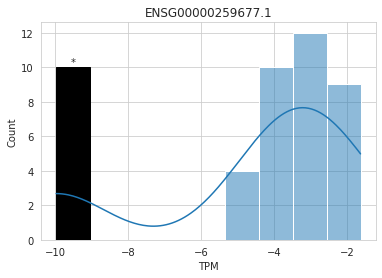

In [54]:
ax = sns.histplot(chol_matrix.T[outlier_gene], kde=True)
ax.set_title(outlier_gene)
ax.set_xlabel('TPM')

# add a marker over the bin the sample lands in
current = quantile_outliers[quantile_outliers.gene == outlier_gene].iloc[0].tpm

for p in ax.patches:
  if current >= p.get_x() and current <= p.get_x() + p.get_width():
      p.set_color('black')
      plt.text(
          p.get_x() + (p.get_width() / 2),
          p.get_height(),
          '*',
          horizontalalignment='center',
          verticalalignment='bottom',
      )

## Creating the Report Input

Since the required input to the IPR python adaptor is JSON we will format the output from this analysis to match that specification. Note this will only contain the expression relevant portions.

We will start by combining the percentile, tpm, and kiqr into a single matrix

In [55]:
metrics_df = pd.concat([
  quantiles.set_index('gene'), 
  percentiles[[test_sample_id]].rename(columns={test_sample_id: 'percentile'})
], axis=1)
metrics_df

,tpm,q1,q2,q3,iqr,kiqr,percentile
gene,,,,,,,
ENSG00000242268.2,-9.9658,-9.9658,-9.9658,-9.9658,0.0000,NaN,46.0
ENSG00000259041.1,-9.9658,-9.9658,-9.9658,-9.9658,0.0000,NaN,51.0
ENSG00000270112.3,-9.9658,-9.9658,-9.9658,-9.9658,0.0000,NaN,44.0
ENSG00000167578.16,4.8905,4.0046,4.6525,5.0104,1.0058,0.236628,69.0
ENSG00000278814.1,-9.9658,-9.9658,-9.9658,-9.9658,0.0000,NaN,51.0
...,...,...,...,...,...,...,...
ENSG00000273233.1,-9.9658,-9.9658,-3.4580,-3.0469,6.9189,-0.940583,23.0
ENSG00000105063.18,5.0352,4.6713,4.9978,5.2327,0.5614,0.066619,56.0
ENSG00000231119.2,-2.4659,-4.6082,-3.8160,-3.1714,1.4368,0.939658,92.0


Next we are going to use our thresholds to assign labels

In [56]:
percentile_threshold = 97.5
kiqr_threshold = 2.5


metrics_df.loc[(metrics_df.percentile >= percentile_threshold) & (metrics_df.kiqr >= kiqr_threshold), 'kbCategory'] = 'increased expression'
metrics_df.loc[(metrics_df.percentile <= 100 - percentile_threshold) & (metrics_df.kiqr <= -1 * kiqr_threshold), 'kbCategory'] = 'reduced expression'

metrics_df[~metrics_df.kbCategory.isnull()]

,tpm,q1,q2,q3,iqr,kiqr,percentile,kbCategory
gene,,,,,,,,
ENSG00000057149.14,4.7464,-9.9658,-9.9658,-5.5735,4.3923,3.349544,100.0,increased expression
ENSG00000140522.11,0.0580,-9.9658,-9.9658,-6.5064,3.4594,2.897554,100.0,increased expression
ENSG00000089116.3,-0.0277,-9.9658,-9.9658,-6.5064,3.4594,2.872781,100.0,increased expression
ENSG00000087495.16,4.8095,-3.0469,-2.0529,-0.4325,2.6144,2.624847,98.0,increased expression
ENSG00000272702.1,-6.5064,-2.5479,-1.5951,-1.1488,1.3991,-3.510328,2.0,reduced expression
ENSG00000254231.1,-2.2447,0.5955,1.2756,1.9527,1.3572,-2.593796,2.0,reduced expression
ENSG00000073282.12,1.4652,-4.2934,-3.6259,-2.3884,1.9050,2.672493,100.0,increased expression
ENSG00000142700.11,0.3796,-9.9658,-9.9658,-6.5064,3.4594,2.990519,100.0,increased expression
ENSG00000077616.10,1.1641,-2.6349,-2.1779,-1.4699,1.1650,2.868670,100.0,increased expression


Finally we can use this to create our output. The percentiles and kIQR values we have calculated above were for our disease comparator but a similar process would be used for normal and biopsy comparators

In [57]:
metrics_df = metrics_df.rename(columns={'kiqr': 'diseasekIQR', 'percentile': 'diseasePercentile'}).reset_index()


We often leave non-variant expression records in to supplement the copy variant and structural variant information, for these records the kbCategory field is a null value since they are not an expression outlier

In [62]:
expression_variants = metrics_df[['tpm', 'diseasekIQR', 'diseasePercentile', 'gene', 'kbCategory']].replace({np.nan:None}).to_dict('records')
expression_variants[0]

{'diseasePercentile': 46.0,
 'diseasekIQR': None,
 'gene': 'ENSG00000242268.2',
 'kbCategory': None,
 'tpm': -9.9658}

We will also add the disease comparator information to the JSON

In [63]:
output_json = {
    'comparators': [
        {'analysisRole': 'expression (disease)', 'name': 'TCGA CHOL', 'size': chol_matrix.shape[0]}
    ],
    'expressionVariants': expression_variants
}
with open('result.json', 'w') as fh:
  json.dump(output_json, fh)